In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spla
# import tensorflow as tf
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms 
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm
from numpy.polynomial.chebyshev import chebval
from ml_collections import config_dict
import scipy.sparse as sparse
import os, sys

LARGE_FILE_PATH = os.path.join('..','data')
DATA_PATH = os.path.join('..','results')
os.makedirs(DATA_PATH, exist_ok = True) 

font = {'weight' : 'bold',
        'size'   : 12}
legend = {'fontsize': 16}
lines = {'linewidth':3, 'markersize':9}
plt.rc('font', **font) 
plt.rc('legend', **legend)
plt.rc('lines', **lines)

markers = ['o','^','s','p','d']
colors = ['b','g','r','c','m','y']

# Utils

In [7]:
def power_iteration(A,Omega,p, krylov=False):
    '''
    A: ndarray(shape=(m,n))
    Omega: ndarray(shape=(n,l))
    p: non-negative int
    Acol: ndarray(shape=(m,l)), ((A@A.T)**p)@A@Omega with orthonormalization
    '''
    l = Omega.shape[-1]
    X = A@Omega #(m,l)
    Qcol,_ = spla.qr(X, mode='economic') #(m,l)
    for iter in range(p):
        if krylov:
            Qrow,_ = spla.qr(A.T@Qcol, mode='economic') #(n,l*(iter+1))
            Qcol,_ = spla.qr(A @ np.hstack((Qrow,Omega)),mode='economic') #(m,l*(iter+2))
        else:
            Qrow,_ = spla.qr(A.T@Qcol[:,-l:], mode='economic') #(n,l)
            Qcol,_ = spla.qr(A@Qrow,mode='economic') #(m,l)
    return Qcol.astype(np.double)


def rsvd(A, k, l=None, power_iter=0, algo='rsvd', return_Omega=0, 
         embedding=lambda d,l: np.random.randn(d,l)/np.sqrt(l)):
    '''
    * algo: 'rsvd'(default, Halko2011), 'gn'(generalized Nystrom), 'bk'(block Krylov)
    * return_Omega: 0 = not return, 1 = return embedding, 2 = return embedding + distribution
    '''
    if l is None:
        l = min(k+10, A.shape[1])

    # construct low-rank approximation
    if algo=='bk': # block krylov (ignoring l)
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Qcol = power_iteration(A,Omega,power_iter,krylov=True) #(m,l*(p+1))
        Uap_reduced, sap, Vhap = spla.svd(Qcol.T @ A, full_matrices=False, lapack_driver='gesvd') #(l*(p+1),l*(p+1)),(l*(p+1),),(l*(p+1),n)
        Uap = Qcol @ Uap_reduced #(m,l*(p+1))
    elif algo=='gn': # generalized Nystrom
        l_large = np.ceil(1.5*k)
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Gamma = embedding(A.shape[0],l_large).astype(np.double) #(m,l_large)
        Qcol = power_iteration(A,Omega,power_iter) #(m,l)
        Qrow = power_iteration(A.T,Gamma,0) #(n,l_large)
        core = (Qcol.T @ A) @ Qrow #(l,l_large)
        Uap_reduced, sap, Vhap_reduced = spla.svd(core, full_matrices=False, lapack_driver='gesvd') #(l,l),(l,),(l,l_large)
        Uap = Qcol @ Uap_reduced #(m,l)
        Vhap = Vhap_reduced @ Qrow.T #(l,n)
    else: # rsvd
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Qcol = power_iteration(A,Omega,power_iter) #(m,l)
        Uap_reduced, sap, Vhap = spla.svd(Qcol.T @ A, full_matrices=False, lapack_driver='gesvd') #(l,l),(l,),(l,n)
        Uap = Qcol @ Uap_reduced #(m,l)
    
    # output
    if return_Omega==1:
        return Uap, sap, Vhap, Omega
    elif return_Omega==2:
        return Uap, sap, Vhap, Omega, embedding
    else:
        return Uap, sap, Vhap


def matdivide(A,B, compute_spectrum=False, tol=1e-16):
    '''
    A: (m,n) ndarray
    B: (k,n) ndarray
    compute A*pinv(B), or its spectrum
    '''
    U,s,Vh = spla.svd(B, full_matrices=False, lapack_driver='gesvd')
    r = np.count_nonzero(s>tol)
    Aux = (A @ Vh[:r].T)/s[:r].reshape(1,-1) #(m,r)
    if compute_spectrum:
        spectrum = spla.svd(Aux, compute_uv=False, lapack_driver='gesvd')
        return spectrum
    else:
        return (Aux @ U[:,:r].T) #(m,k)


def canonical_angles(U,V, check_ortho=True, tol=1e-16):
    '''
    Input
    -----
    * U: ndarray(shape=(d,k)) (d>k)
    * V: ndarray(shape=(d,l)) (d>l)
    Output
    ------
    * min(k,l) sin's and cos's, descending
    '''
    U = U.astype(np.longdouble)
    V = V.astype(np.longdouble)
    if check_ortho:
        U,_ = spla.qr(U, mode='economic')
        V,_ = spla.qr(V, mode='economic')
    Mcos = U.T @ V # (k,l)
    cos = spla.svd(Mcos, full_matrices=False, compute_uv=False, lapack_driver='gesvd')
    if cos[0]>=1. or cos[-1]<tol: # compute sin instead for highly overlapped (U,V)
        if U.shape[-1]>V.shape[-1]: #k>l
            Msin = V - U @ Mcos #(d,l)
        else: #l>=k
            Msin = U - V @ Mcos.T #(d,k)
        sin = spla.svd(Msin, full_matrices=False, compute_uv=False, lapack_driver='gesvd')
        return np.flip(sin)
    else:
        return np.sqrt(1.-cos**2)

## Target generater

9913344it [00:00, 17247376.42it/s]                             


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



29696it [00:00, 13503257.98it/s]         


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



1649664it [00:00, 10014462.33it/s]                           


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



5120it [00:00, 26252856.33it/s]         


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



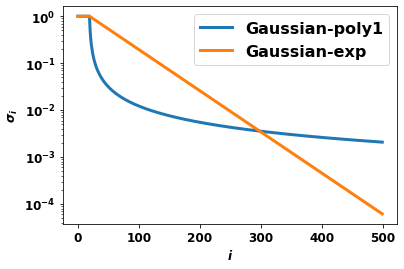

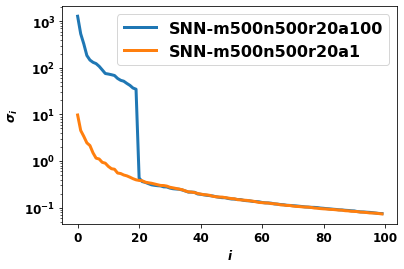

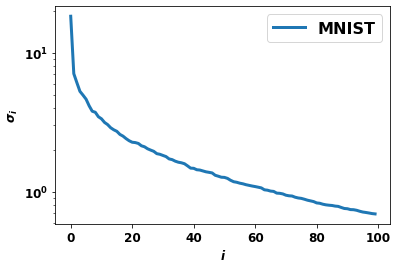

In [8]:
def genenrate_mnist_target(size=800):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)), 
                   'U':ndarray(shape=(m,r)), 
                   's':ndarray(shape=(r,)), 
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    dataset = datasets.MNIST(root=LARGE_FILE_PATH, train=False, download=True, transform=transforms.ToTensor())
    dataloader = DataLoader(dataset, batch_size=size, shuffle=True)
    X,_ = next(iter(dataloader))
    X = X.view(size,-1).numpy().astype(np.double)
    X = X / spla.norm(X, ord=2, axis=1, keepdims=True)
    U,s,Vh = spla.svd(X, full_matrices=False, lapack_driver='gesvd')
    target = {'A': X.astype(np.double), 
              'U': U.astype(np.double), 
              's': s.astype(np.double),
              'V': Vh.T.astype(np.double),
              'tag': 'mnist-train%d'%(size)}
    return target


def genenrate_gaussian_target(m=1000, n=1000, rank=1000, spectrum=None):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)), 
                   'U':ndarray(shape=(m,r)), 
                   's':ndarray(shape=(r,)), 
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    if spectrum is None:
        spectrum = np.linspace(1.0, 1e-5, num=rank)
    elif len(spectrum)<rank:
        spectrum = np.concatenate((spectrum, np.zeros(rank-len(spectrum))))
    U,_ = spla.qr(np.random.randn(m,rank), mode='economic')
    V,_ = spla.qr(np.random.randn(n,rank), mode='economic')
    target = {'A': (( U*(spectrum[:rank].reshape((1,-1))) )@V.T).astype(np.double), 
              'U': U.astype(np.double), 
              's': spectrum[:rank].astype(np.double),
              'V': V.astype(np.double),
              'tag': 'Gaussian'}
    return target


def generate_sparse_nonnegative_target(m=1000, n=1000, r1=20, amp=10., sparsity=0.05):
    r = min(m,n)
    weights = np.concatenate((amp/np.arange(1,r1+1), 1./np.arange(r1+1,r+1))) #(r,)
    X = sparse.random(m, r, density=sparsity, format='csr').toarray()
    Y = sparse.random(m, r, density=sparsity, format='csr').toarray()
    A = (X@(weights*Y))
    U,s,Vh = spla.svd(A, full_matrices=False, lapack_driver='gesvd')
    target = {'A': A.astype(np.double), 
              'U': U.astype(np.double), 
              's': s.astype(np.double),
              'V': Vh.T.astype(np.double),
              'tag': f'SNN-m{m:d}n{n:d}r{r1:d}a{amp:.0f}'}
    return target


def visualize_spec(spectra, range=100):
    plt.figure()
    for name, spec in spectra.items():
        plt.semilogy(spec[:range], label=name)
    plt.xlabel('$i$')
    plt.ylabel('$\sigma_i$')
    plt.legend()
    plt.show()


def get_targets(m=500, n=500, r1=20, verbose=False, tol=1e-5):
    spectra= {  'poly0d5': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./(np.arange(2,r-r1+2))**.5))),
                'poly1': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./np.arange(2,r-r1+2)))),
                'poly2': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./(np.arange(2,r-r1+2))**2))),
                'exp': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,0.98**(np.arange(1,r-r1+1))))),
              }
    targets = OrderedDict()
    # Gaussian random
    spectra_gaussian = dict()
    r = min(m,n)
    for decay in ['poly1','exp']:
        tag = f'Gaussian-{decay:s}'
        targets[tag] = genenrate_gaussian_target(m=m, n=n, rank=r, spectrum=spectra[decay](r))
        targets[tag]['tag'] = tag 
        spectra_gaussian[tag] = targets[tag]['s']
    # SNN
    spectra_snn = dict()
    for amp in [100,1]:
        tag = f'SNN-m{m:d}n{n:d}r{r1:d}a{amp:.0f}'
        targets[tag] = generate_sparse_nonnegative_target(m, n, r1, amp, sparsity=0.05)
        spectra_snn[tag] = targets[tag]['s']
    # MNIST
    N = 800
    targets['MNIST'] = genenrate_mnist_target(size=N)
    if verbose:
        visualize_spec(spectra_gaussian, range=500)
        visualize_spec(spectra_snn, range=100)
        visualize_spec({'MNIST':targets['MNIST']['s']}, range=100)

    return targets


_ = get_targets(verbose=True)

# Bounds \& Estimators

## Residual-based bound


In [4]:
def residual_based_bound(E, spec, k, return_verbose=False):
    '''
    Input
    -----
    * Res: (A - \wh{A}_l)@V_k (or \wh{V}_k), shape=(m,k)
    * spec: >=k sv's of A
    Output
    ------
    * sin(\theta_i): shape=(k,), canonical angle in descending order
    '''
    sigmaRes = spla.svd(E, full_matrices=False, compute_uv=False, lapack_driver='gesvd')
    bound1 = sigmaRes[0]/spec[:k]
    bound2 = np.flip(sigmaRes[:k])/spec[k-1]
    cangles = np.minimum(bound1, bound2)
    if return_verbose:
        return cangles, bound1, bound2 
    else:
        return cangles

## Subresidual-based bound

In [5]:
def subresidual_based_bound(A, s, s_l, U_l, V_l, k, l, ord=2):
    '''
    * ord: 2=max canonical angle, fro=l_2 of all canonical angles
    Output
    ------
    * >= sin\angle(U_k, \hat U_l): np.float in [0,1], upper bound for the max canonical angle 
    * >= sin\angle(V_k, \hat V_l): np.float in [0,1], upper bound for the max canonical angle 
    * >= sin\angle(U_k, \hat U_k): np.float in [0,1], upper bound for the max canonical angle 
    * >= sin\angle(U_k, \hat U_k): np.float in [0,1], upper bound for the max canonical angle 
    '''
    E33 = A - (A @ V_l) @ V_l.T
    Stall = A@V_l - U_l*s_l.reshape((1,-1)) #(m,l)   
    norm_E33 = spla.norm(E33, ord=2)
    norm_E32 = spla.norm(Stall[:,k:], ord=2)
    norm_E3 = spla.norm(Stall, ord=ord)
    if s[k-1] < s_l[k] or s[k-1] < norm_E33:
        print(f's(k)={s[k-1]:-10.4e}, sap(k+1)={s_l[k]:-10.4e}, ||E_33||_2={norm_E33:-10.4e}')
    gap_1 = (s[k-1]**2 - s_l[k]**2)/s[k-1]
    gap_2 = (s[k-1]**2 - s_l[k]**2)/s_l[k]
    Gap_1 = (s[k-1]**2 - norm_E33**2)/s[k-1]
    Gap_2 = (s[k-1]**2 - norm_E33**2)/norm_E33

    cang_U_kl = norm_E3 / Gap_1 * (s[k-1]/s[:k])
    cang_V_kl = norm_E3 / Gap_2 * (s[k-1]/s[:k])
    cang_U_kk = np.sqrt(1+(norm_E32/gap_2*s[k-1]/s[:k])**2)*norm_E3/Gap_1 
    cang_V_kk = np.sqrt((norm_E33/s[k-1])**2+(norm_E32/gap_1*s[k-1]/s[:k])**2)*norm_E3/Gap_1 

    return cang_U_kl, cang_V_kl, cang_U_kk, cang_V_kk

## Space-agnostic bounds

In [6]:
def space_agnostic_bound(spec, k, l, p, eps=1.0, tol=1e-16):
    # polynomial for power-iteration
    pstar = lambda x: x**(2*p+1)  
    pspec = pstar(spec)**2
    # eps = min(eps, np.sqrt(l/k), np.sqrt((len(spec)-k)/l))
    eps1 = eps*np.sqrt(k/l)
    eps2 = eps*np.sqrt(l/(len(spec)-k))
    upper = np.maximum(tol, (1. + (1-eps1)/(1+eps2)*l/pspec[k:].sum()*pspec[:k])**(-.5))
    return upper

def space_agnostic_lower(spec, k, l, p, eps=1e3, tol=1e-16):
    # polynomial for power-iteration
    pstar = lambda x: x**(2*p+1)  
    pspec = pstar(spec)**2
    # eps = min(eps, np.sqrt(l/k), np.sqrt((len(spec)-k)/l))
    eps1 = eps*np.sqrt(k/l)
    eps2 = eps*np.sqrt(l/(len(spec)-k))
    lower = np.maximum(tol, (1. + (1+eps1)/max(1-eps2,1e-16)*l/pspec[k:].sum()*pspec[:k])**(-.5))
    return lower

## Space-agnostic estimations

In [7]:
def space_agnostic_estmation(embedding, spec, k, l, p, n_trial=1, return_trials=False, tol=1e-16):
    '''
    Input
    -----
    * embedding: lambda d,l, distribution of embeddings
    * spec: shape=(r,), descending order, non-negative
    * p: p for U, p+0.5 for V 
    
    Output
    ------
    * Given VTOmega -> return sin_est
    * None VTOmega -> repeat, return sin_est_all.mean(axis=0), sin_est_all
    '''
    def _rsvd_mixed_spec_bound(Omega): # Omega.shape=(r,l)
        assert Omega.shape[0]==len(spec), f'Dimension mismatch: Omega.shape[0]={Omega.shape[0]:d}, len(spec)={len(spec):d}'
        # polynomial for power-iteration
        pstar = lambda x: np.maximum(x**(2*p+1),tol)  
        # lower bound: alpha  
        WOmega = pstar(spec).reshape((-1,1))*Omega #(r,l)   
        alpha = matdivide(WOmega[:k], WOmega[k:], compute_spectrum=True) #(k,r-k)->k      
        upper_sq = np.maximum(1./np.sqrt(1+alpha**2), tol)
        return upper_sq

    r = spec.shape[0]
    upper_all = []
    for _ in range(n_trial):
        Omega = embedding(r,l)
        upper_tmp = _rsvd_mixed_spec_bound(Omega)  
        upper_all.append(upper_tmp)
    upper_all = np.array(upper_all)
    upper = upper_all.mean(axis=0)
    upper_range = np.vstack((upper, upper_all.min(axis=0), upper_all.max(axis=0)))
    if return_trials:
        return upper_range
    else:
        return upper

## Saibaba 2018, Theorem 1

In [8]:

def saibaba2018_thm1(k, p, spec, VTOmega, tol=1e-16):
    Omega1 = VTOmega[:k] #(k,l)
    Omega2 = VTOmega[k:] #(r-k,l)
    C_true = matdivide(Omega2, Omega1, compute_spectrum=True)[0]
    gaps = spec[k+1]/spec[:k] #(k,)
    upper = C_true * gaps**(2*p+1)
    upper = np.maximum(upper / np.sqrt(1 + upper**2),tol)
    return upper

## Canonical angle wrapper

In [9]:
cang_bound_map = {
    'res': 'Thm2',
    'subres': 'Thm3',
    'sa_bd': 'Thm1',
    'sa_lower': 'Thm1 Lower',
    'sa_est': 'Prop1',
    'saibaba2018': 'S2018 Thm 1' 
}
cang_spec_map = {
    'true': r'$\sigma$',
    'rsvd': r'$\hat{\sigma}$',
}
tag_format = lambda bound, spec: f'{bound:s} w/ {spec:s}'
cang_marker_map = {
    # (U_k,X), (V_k,Y)
    tag_format(cang_bound_map['res'], cang_spec_map['true']): 'co-',
    tag_format(cang_bound_map['res'], cang_spec_map['rsvd']): 'co:',
    tag_format(cang_bound_map['subres'], cang_spec_map['true']): 'g^-',
    tag_format(cang_bound_map['subres'], cang_spec_map['rsvd']): 'g^:',
    tag_format(cang_bound_map['sa_bd'], cang_spec_map['true']): 'rs-',
    tag_format(cang_bound_map['sa_bd'], cang_spec_map['rsvd']): 'rs:',
    tag_format(cang_bound_map['sa_lower'], cang_spec_map['true']): 'bs-',
    tag_format(cang_bound_map['sa_lower'], cang_spec_map['rsvd']): 'bs:',
    tag_format(cang_bound_map['sa_est'], cang_spec_map['true']): 'bX-',
    tag_format(cang_bound_map['sa_est'], cang_spec_map['rsvd']): 'bX:',
    tag_format(cang_bound_map['saibaba2018'], cang_spec_map['true']): 'md-',
    tag_format(cang_bound_map['saibaba2018'], cang_spec_map['rsvd']): 'md:',
    # true cangles
    r'$\sin\angle(U_k,X)$': 'k-',
    r'$\sin\angle(V_k,Y)$': 'k-',
    r'$\sin\angle(U_k,\hat{U}_k)$': 'k-',
    r'$\sin\angle(V_k,\hat{V}_k)$': 'k-'
} 

def eval_cang(target, k, l, p, n_trial=3, eps_space_agno=1.0, eps_space_agno_lower=1.0, tol=1e-16, upper=True):
    cang = config_dict.ConfigDict()

    # target
    A = target['A']
    U = target['U']
    V = target['V']
    s = target['s']
    rank = len(s)
    target_tag = target['tag']
    cang.tag = target_tag
    cang.s = s
    cang.k = k
    cang.l = l
    cang.p = p 
    cang.n_trial = n_trial
    cang.eps_space_agno = eps_space_agno
    cang.tol = tol

    U_l, s_l, Vh_l, Omega, embedding = rsvd(A,k,l=l, power_iter=p, algo='rsvd', return_Omega=2)
    V_l = Vh_l.T
    E_U = A - (U_l * s_l.reshape((1,-1))) @ Vh_l
    E_V = A - (A@V_l)@Vh_l
    s_r = np.concatenate((s_l, np.ones(len(s)-len(s_l))*s_l[-1])) #(r,)
    VTOmega = V.T @ Omega
    cang.s_r = s_r 

    spectra = {
        cang_spec_map['true']: s,
        cang_spec_map['rsvd']: s_r,
    }
    
    cang.Ukl = OrderedDict()
    cang.Vkl = OrderedDict()
    cang.Ukk = OrderedDict()
    cang.Vkk = OrderedDict()
    
    if upper:
        bounds = {
            cang_bound_map['sa_bd']: lambda spec, piter=p, E=None: space_agnostic_bound(spec, k, l, piter, eps=eps_space_agno, tol=tol),
            cang_bound_map['sa_est']: lambda spec, piter=p, E=None: space_agnostic_estmation(embedding, spec, k, l, piter, n_trial=n_trial, return_trials=True, tol=tol),
            cang_bound_map['res']: lambda spec, piter=None, E=E_U: residual_based_bound(E, spec, k),
            cang_bound_map['saibaba2018']: lambda spec, piter=p, E=None: saibaba2018_thm1(k, piter, spec, VTOmega, tol=tol),
        }
        # Subresidual-based
        for spec_tag, spec in spectra.items():
            bound_tag = tag_format(cang_bound_map['subres'], spec_tag)
            cang_U_kl, cang_V_kl, cang_U_kk, cang_V_kk = subresidual_based_bound(A, spec, s_l, U_l, V_l, k, l, ord=2)
            cang.Ukl[bound_tag] = cang_U_kl
            cang.Vkl[bound_tag] = cang_V_kl
            cang.Ukk[bound_tag] = cang_U_kk
            cang.Vkk[bound_tag] = cang_V_kk
    else: # lower bounds
        bounds = {
            cang_bound_map['sa_bd']: lambda spec, piter=p, E=None: space_agnostic_bound(spec, k, l, piter, eps=eps_space_agno, tol=tol),
            cang_bound_map['sa_lower']: lambda spec, piter=p, E=None: space_agnostic_lower(spec, k, l, piter, eps=eps_space_agno_lower, tol=tol),
        }
        
    # bounds
    for bound_tag, bound in bounds.items():
        for spec_tag, spec in spectra.items():
            bound_tag_aux = tag_format(bound_tag, spec_tag)
            cang.Ukl[bound_tag_aux] = bound(spec, piter=p, E=E_U)
            cang.Vkl[bound_tag_aux] = bound(spec, piter=p+0.5, E=E_V)
    # true canonical angles 
    cang.Ukl[r'$\sin\angle(U_k,X)$'] = canonical_angles(U[:,:k],U_l[:,:l])
    cang.Ukk[r'$\sin\angle(U_k,\hat{U}_k)$'] = canonical_angles(U[:,:k],U_l[:,:k])
    cang.Vkl[r'$\sin\angle(V_k,Y)$'] = canonical_angles(V[:,:k],V_l[:,:l])
    cang.Vkk[r'$\sin\angle(V_k,\hat{V}_k)$'] = canonical_angles(V[:,:k],V_l[:,:k])
    return cang


def plot_cang(cang, markers, semilogy=True, legend=False, subplot_grid=(1,2), subplot_start_count=0):
    '''
    * cang.keys() = {tag, k, l, p, n_trial, eps_space_agno, tol, s, s_r, Ukl, Vkl, Ukk, Vkk}
    '''
    ii = np.arange(cang.k)
    def _plot_cang(cang_dict):
        for key,val in cang_dict.items():
            if len(val.shape)>1 and val.shape[0]==3:
                plt.fill_between(ii, val[1], val[2], color=markers[key][0], alpha=0.2)   
            else:
                val = val.reshape((1,-1))
            max_angle = f'{val[0][-1]:.1e}'
            # plt.plot(ii, val[0], markers[key], markevery=7, label=f'{key:s}<={max_angle:s}')    
            plt.plot(ii, val[0], markers[key], markevery=7, label=f'{key:s}')
        if semilogy:
            ax = plt.gca()
            ax.set_yscale('log')
        plt.grid() 

    plt.subplot(*subplot_grid, subplot_start_count+1)
    _plot_cang(cang.Ukl)
    plt.title(r'$\sin\angle(U_k,X)$'+f', $k={cang.k:d},~l={cang.l:d},~q={cang.p:d}$')
    if legend: 
        ax = plt.gca()
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[1:] + handles[:1]
        labels = labels[1:] + labels[:1]
        lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.15, -0.1), ncol=6)
        lgds = [lgd]
    else:
        lgds = []
    
    plt.subplot(*subplot_grid, subplot_start_count+2)
    _plot_cang(cang.Vkl)
    plt.title(r'$\sin\angle(V_k,Y)$'+f', $k={cang.k:d},~l={cang.l:d},~q={cang.p:d}$')

    return lgds


def run_all_targets(k=50, l=80, ps=[0,1], **kwargs):
    '''
    * kwargs: n_trial=4, eps_space_agno=1.0, tol=1e-16
    '''
    targets = get_targets(m=500, n=500)
    ps_str = '-'.join([f'{p:d}' for p in ps])
    
    for target in targets.values():
        fig = plt.figure(figsize=(19,3))
        
        all_lgds = []
        for i,p in enumerate(ps):
            cang = eval_cang(target, k, l, p, **kwargs)
            lgds = plot_cang(cang, cang_marker_map, semilogy=True, legend=(i==0), 
                             subplot_grid=(1, 2*len(ps)), subplot_start_count=2*i)
            all_lgds.extend(lgds)
        
        figname = f'{cang.tag:s}-kl_k{cang.k:d}_l{cang.l:d}_p{ps_str:s}.png'
        print(figname)
        plt.savefig(os.path.join(DATA_PATH,figname), bbox_extra_artists=all_lgds, bbox_inches='tight')
        plt.show()

# Experiments

## Small oversampling

Gaussian-poly1-kl_k50_l80_p0-1.png


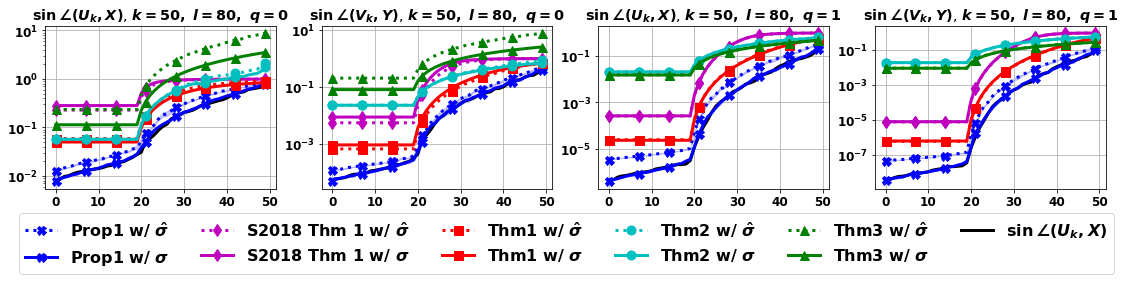

Gaussian-exp-kl_k50_l80_p0-1.png


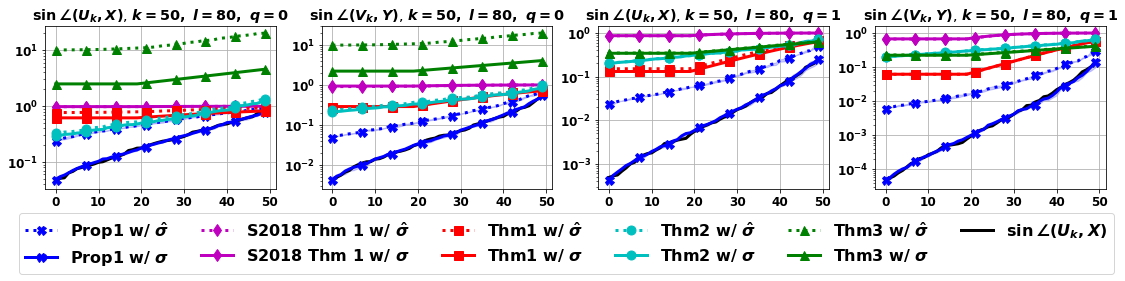

s(k)=1.3190e-01, sap(k+1)=1.3021e-01, ||E_33||_2=1.5358e-01
SNN-m500n500r20a100-kl_k50_l80_p0-1.png


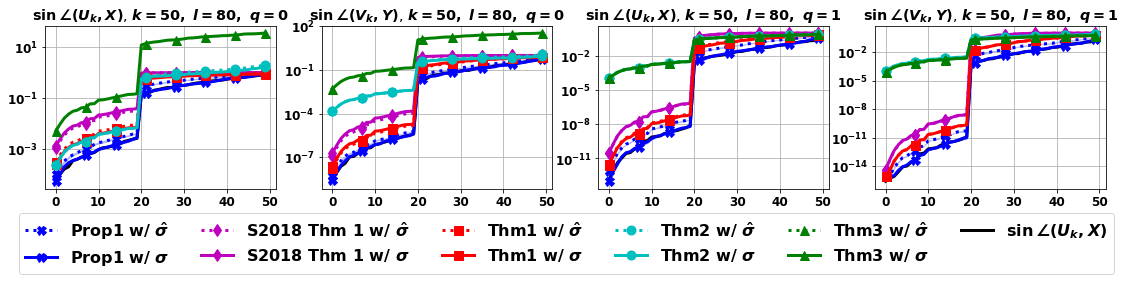

s(k)=1.2716e-01, sap(k+1)=1.2391e-01, ||E_33||_2=1.4741e-01
SNN-m500n500r20a1-kl_k50_l80_p0-1.png


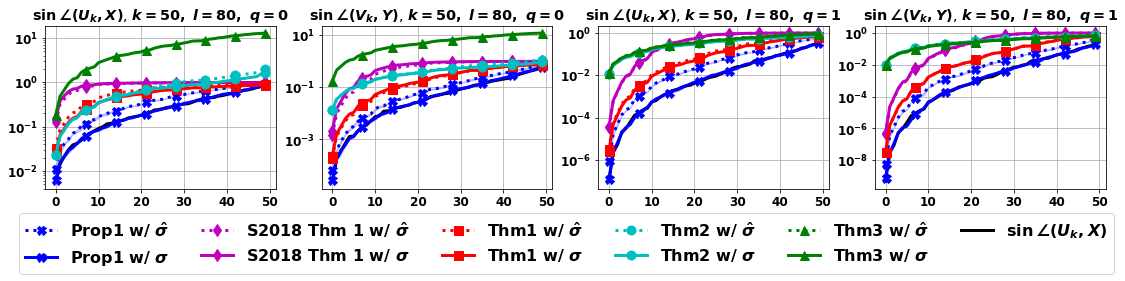

s(k)=1.0239e+00, sap(k+1)=9.9838e-01, ||E_33||_2=1.2483e+00
mnist-train800-kl_k50_l80_p0-1.png


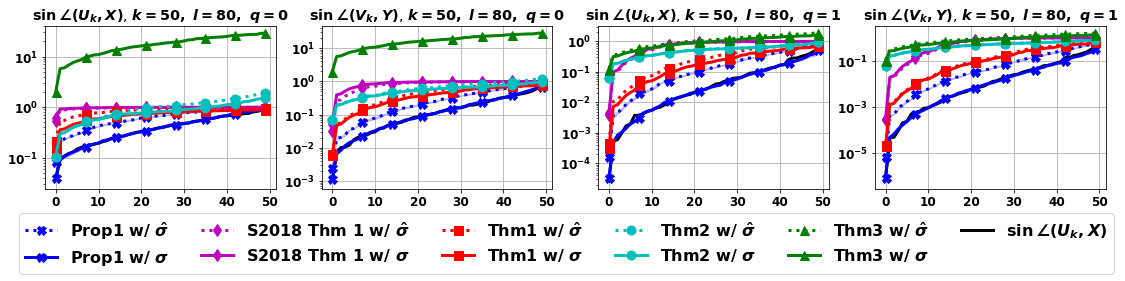

In [14]:
run_all_targets(k=50, l=80, tol=1e-15)

## Large oversampling

Gaussian-poly1-kl_k50_l200_p0-1.png


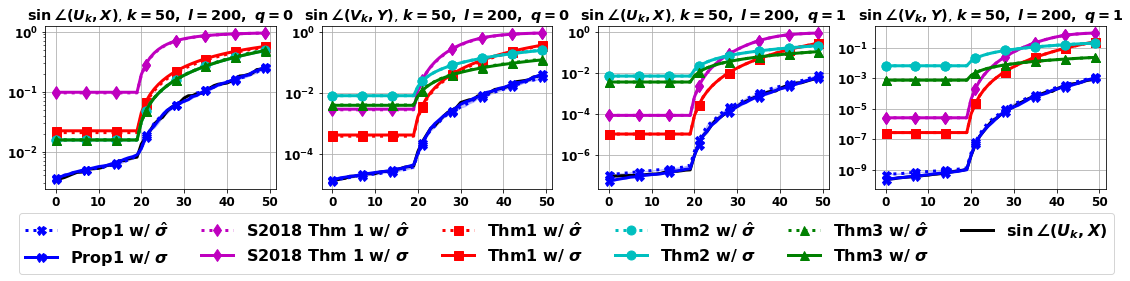

Gaussian-exp-kl_k50_l200_p0-1.png


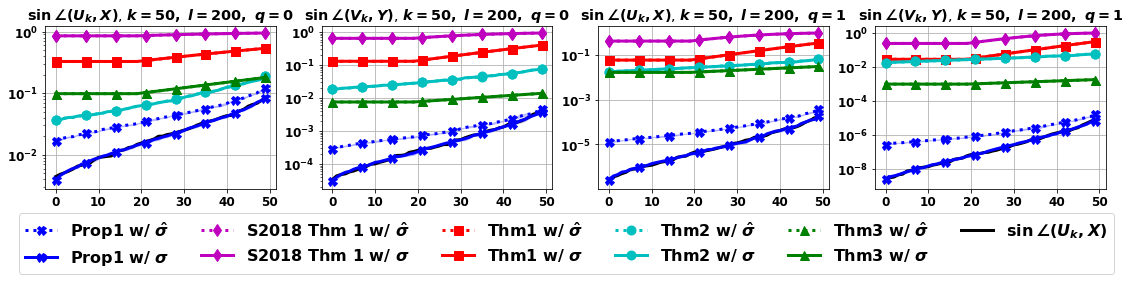

SNN-m500n500r20a100-kl_k50_l200_p0-1.png


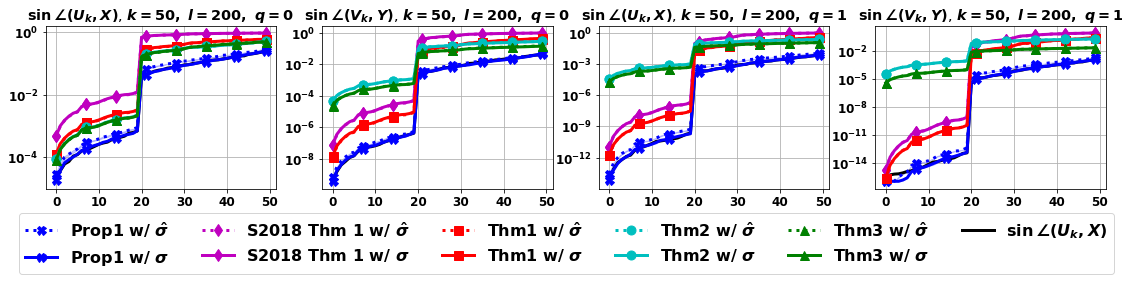

SNN-m500n500r20a1-kl_k50_l200_p0-1.png


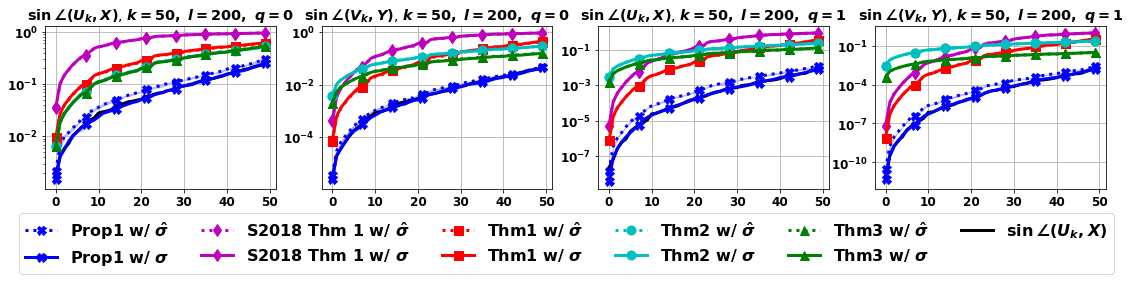

mnist-train800-kl_k50_l200_p0-1.png


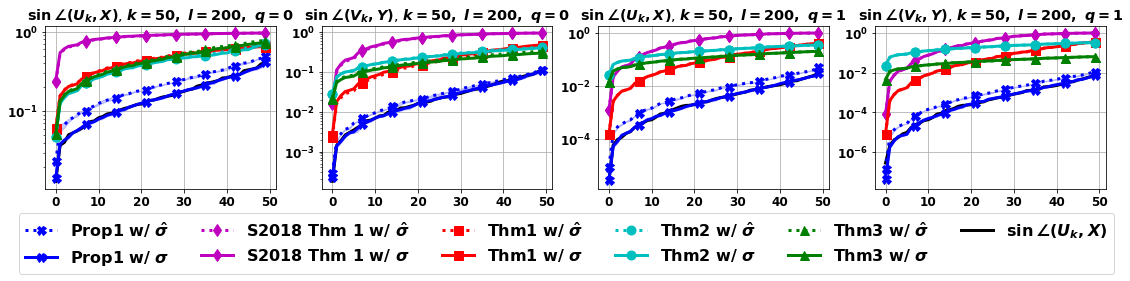

In [73]:
run_all_targets(k=50, l=200)

## Large power iterations

Gaussian-poly1-kl_k50_l80_p5-10.png


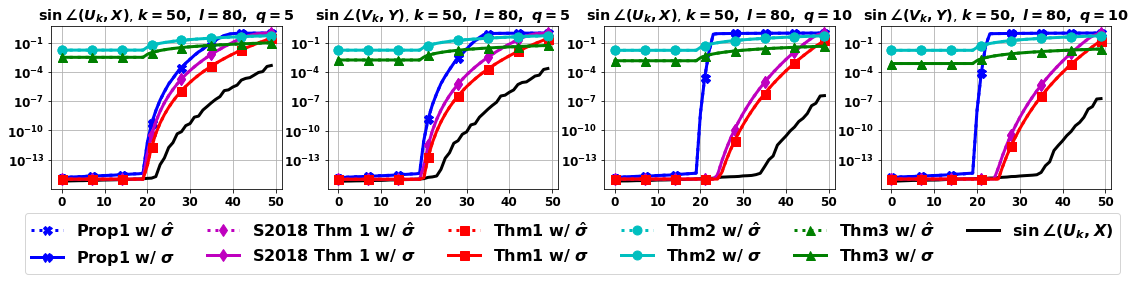

Gaussian-exp-kl_k50_l80_p5-10.png


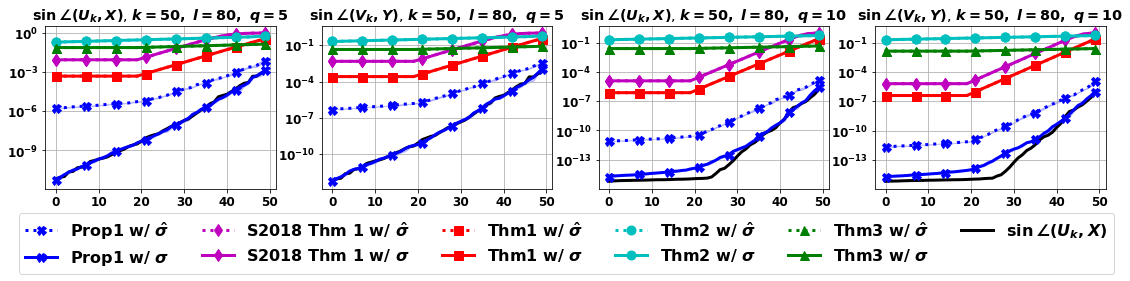

SNN-m500n500r20a100-kl_k50_l80_p5-10.png


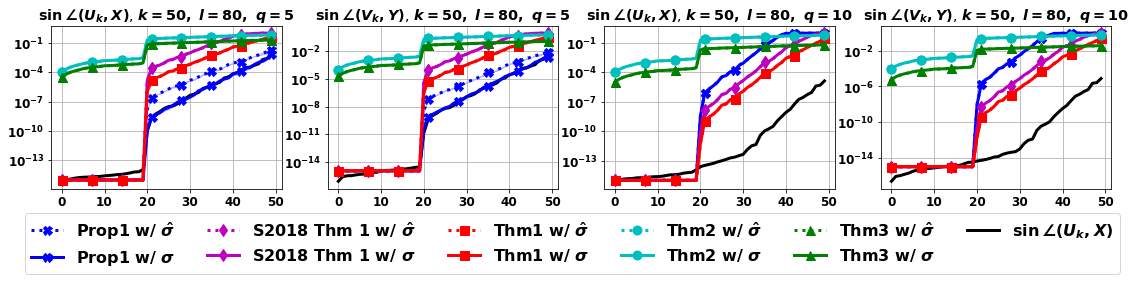

SNN-m500n500r20a1-kl_k50_l80_p5-10.png


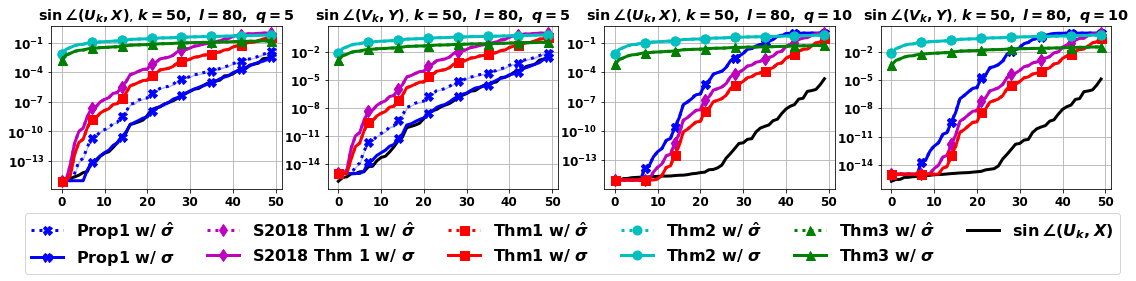

mnist-train800-kl_k50_l80_p5-10.png


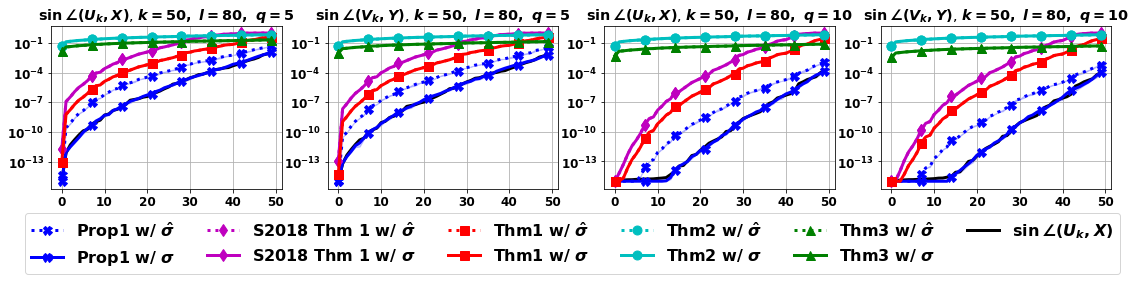

In [13]:
run_all_targets(k=50, l=80, ps=[5,10], tol=1e-15)

## Lower+upper space agnostic

Gaussian-poly1-kl_k50_l200_p0-1.png


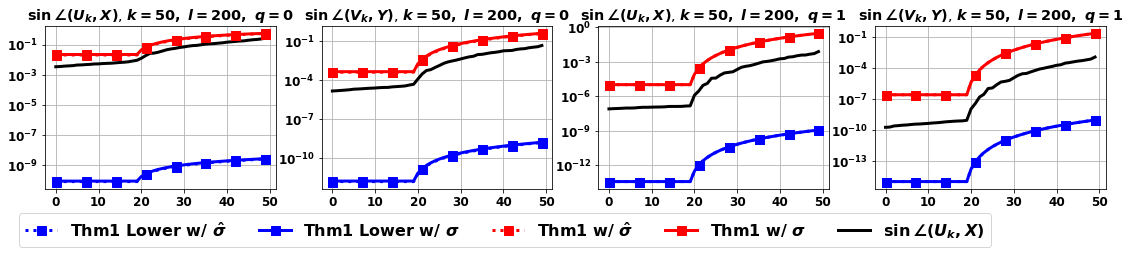

Gaussian-exp-kl_k50_l200_p0-1.png


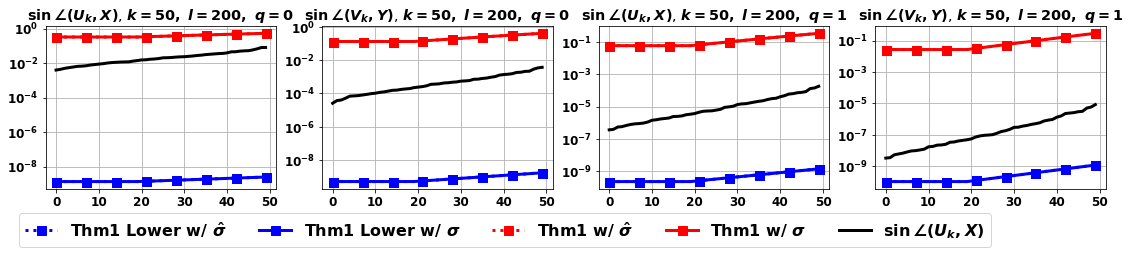

SNN-m500n500r20a100-kl_k50_l200_p0-1.png


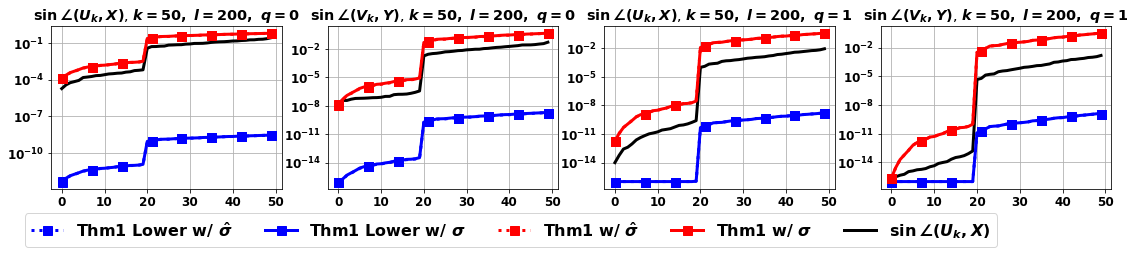

SNN-m500n500r20a1-kl_k50_l200_p0-1.png


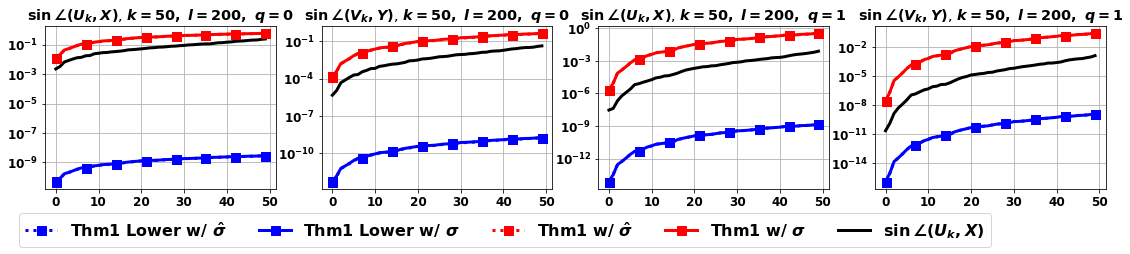

mnist-train800-kl_k50_l200_p0-1.png


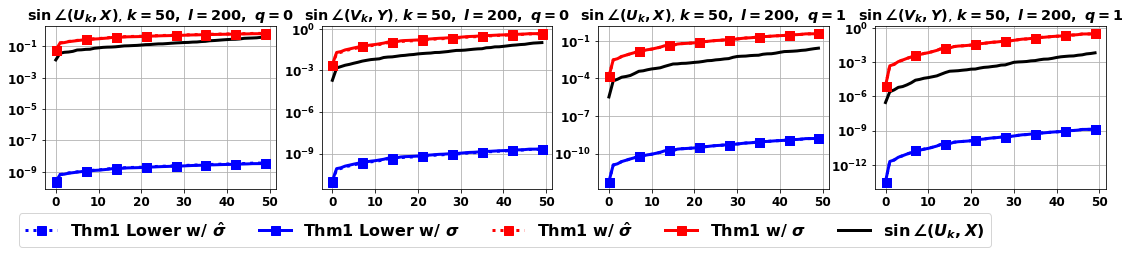

In [22]:
run_all_targets(k=50, l=200, ps=[0,1], eps_space_agno=1.0, eps_space_agno_lower=2.0, tol=1e-16, upper=False)

# Miscellaneous

In [30]:
def space_agnostic_example(alpha=32,beta=64,gamma=2.,gaps=(1.3,1.35,1.4,1.45)):
    for j, gap in enumerate(gaps):
        phi = lambda q: (1 + (np.sqrt(alpha/beta)/np.sqrt(2*q+1)-gamma*np.sqrt(1./beta))/(np.sqrt(beta/alpha)*np.sqrt(2*q+1)+gamma) * (gap**(4*q+2)) )**(-.5)
        xx = np.arange(int(alpha/(2*gamma**2)))
        yy = phi(xx)
        q_opt = np.argmin(yy)
        plt.plot(xx,yy,colors[j]+markers[j]+'-',label='$\sigma_1/\sigma_{k+1}$='+f'${gap:.2f}$, '+'$\hat{q}=$'+f'${q_opt:d}$')
    ax = plt.gca()
    lgd1 = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1) 
    plt.xlabel('$q$ power iterations')   
    plt.ylabel('$\phi_{\gamma}(q)$')  
    plt.title(f'$\\alpha={alpha:d}$, $\\beta={beta:d}$, $\\gamma={gamma:.2f}$')
    plt.grid()  
    return lgd1


def space_agnostic_rsvd_example(k,alpha,beta,gamma,gaps,qs,n_trial=5):
    r = (1+beta)*k
    ls = np.floor(k*alpha/(2*qs+1)).astype(int)
    gap_q = dict()
    for g in gaps:
        gap_q[g] = dict()
        spectrum = np.concatenate((np.ones(k)*g, np.ones(r-k)))
        target = genenrate_gaussian_target(m=r, n=r, rank=r, spectrum=spectrum)
        A = target['A']
        U = target['U']
        for q, l in zip(qs, ls):
            crange = np.vstack((np.zeros(k), -np.ones(k), np.ones(k)))
            for _ in range(n_trial):
                U_l,_,_ = rsvd(A,k,l=l, power_iter=q, algo='rsvd', return_Omega=0)
                cangs = canonical_angles(U[:,:k],U_l[:,:l],check_ortho=True) #(k,)
                crange[0] += cangs
                crange[1] = np.minimum(crange[1],cangs)
                crange[2] = np.maximum(crange[2],cangs)
            crange[0] /= n_trial
            gap_q[g][q] = crange

    # plot
    plt.figure(figsize=(5*(len(gaps)+1),3))
    plt.subplot(1,len(gaps)+1,1)
    lgd1 = space_agnostic_example(alpha,beta,gamma,gaps)
    lgds = [lgd1]

    ii = np.arange(k)+1
    line_styles = ['-', '--', ':']
    for i, gap in enumerate(gaps):
        plt.subplot(1,len(gaps)+1,i+2)
        dict_ql = {gap_q[gap][q][0,-1]: (q,l) for q,l in zip(qs,ls)}
        for j, cangle in enumerate(sorted(dict_ql.keys())):
            q,l = dict_ql[cangle]
            plt.errorbar(ii, gap_q[gap][q][0], yerr=gap_q[gap][q][1:], fmt=colors[i]+markers[i]+line_styles[j], label=f'$l={l:-4d}$, $q={q:-2d}$')
        ax = plt.gca()
        lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1) 
        lgds.append(lgd)
        plt.ylim(top=1.0)
        plt.xlabel('canonical angle $i$')   
        plt.ylabel('$\\sin\\theta_i$')  
        plt.title(f'$k={k:d}$, $r={r:d}$, '+'$\sigma_1/\sigma_{k+1}$='+f'${gap:.2f}$')
        plt.grid()  
    
    figname = f'space-agno-ex_a{alpha:d}-b{beta:d}-g{gamma:.0f}.png'
    plt.savefig(os.path.join(DATA_PATH,figname), bbox_extra_artists=lgds, bbox_inches='tight')

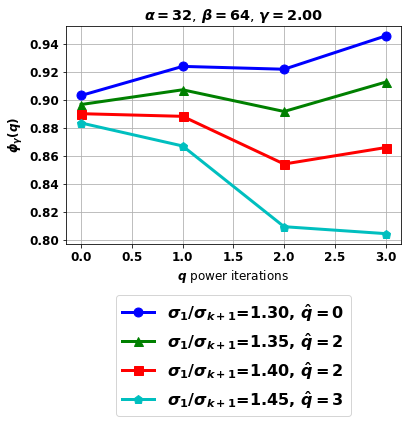

In [31]:
alpha = 2**5
beta = 2**6
gamma = 2.
gaps = [1.3,1.35,1.4,1.45]
space_agnostic_example(alpha,beta,gamma,gaps)

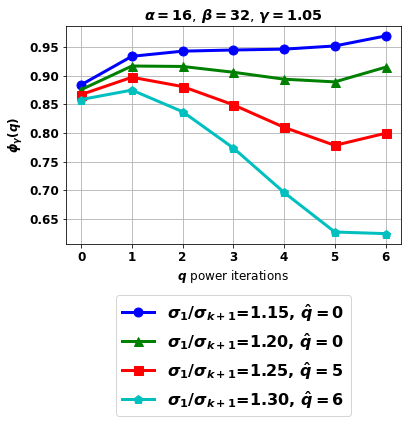

In [32]:
alpha = 2**4
beta = 2**5
gamma = 1.05
gaps = [1.15,1.2,1.25,1.3]
space_agnostic_example(alpha,beta,gamma,gaps)

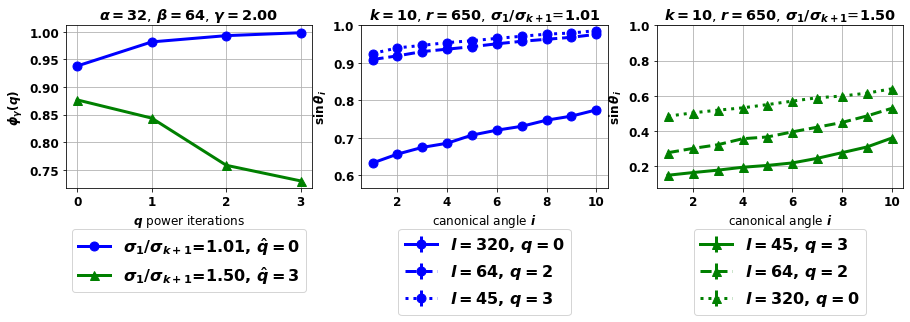

In [41]:
k = 10
alpha = 2**5
beta = 2**6
gamma = 2.
gaps = [1.01,1.5]
qs = np.array([0,2,3])
space_agnostic_rsvd_example(k,alpha,beta,gamma,gaps,qs)

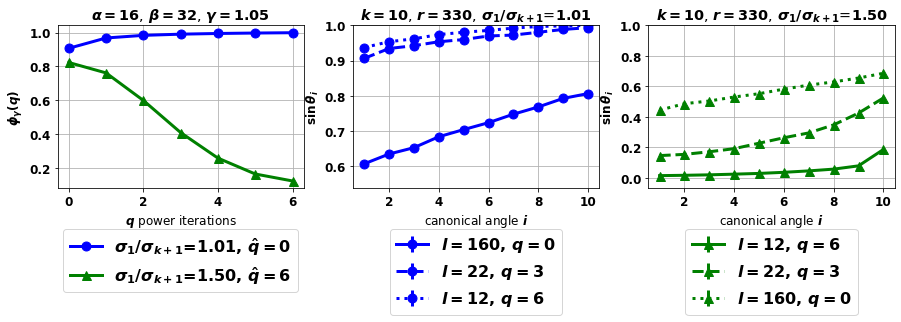

In [40]:
k = 10
alpha = 2**4
beta = 2**5
gamma = 1.05
gaps = [1.01,1.5]
gap = 1.15
qs = np.array([0,3,6])
space_agnostic_rsvd_example(k,alpha,beta,gamma,gaps,qs)